In [20]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\OSSI')
from KNMI_readers import read_knmi_uurgeg
from scipy.signal import welch

import puv 


In [21]:
def solo_data_reader(dataFile, sf):
    '''
    Function to read solo datafile.
    Returns a dataframe with a time column and pressure column in Pascal
    '''
    p = []
    datt = []
    with open(dataFile) as myfile:
        for index, line in enumerate(myfile):
            if index >= 1:
                lin = line.split(',')
                datt.append(lin[0])
                p.append(float(lin[1]))
    p = np.array(p) * 1e4  # dBar to Pa

    t = pd.date_range(datt[0], periods=len(datt), freq='{}S'.format(1 / sf))

    dfp = pd.DataFrame(data={'p': p}, index=t)

    dfp.index.name = 't'
    return dfp

In [22]:
# # input parameters
# # RBRSolo^3
sf = 16  #[hz] sampling frequency
experimentFolder = r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\RBR_05'                  # path where the data is sitting # Rubens Laptop
# experimentFolder = r'U:\'                  # path where the data is sitting # TUD U-Drive


knmiFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\uurgeg_330_2021-2030.txt"  # path to the KNMI data
instrumentName = instrument = 'RBR_05'                                                                              # designated name of the instrument
namedatafile = 'S5 - 208681_20241227_1715_data.txt'                                                          # name of the datafile
dataFile =  os.path.join(experimentFolder, namedatafile)                                                 # path + name datafile
serial_number = '202438'                                                                                 # unique serial number of the instrument
xRD = 72429.072                                                                                          # x position of placement in field
yRD =  452174.014                                                                                        # y position of placement in field
zRD_bedlevel =zb = -0.969         # m NAP
zRD_sensor = zi =  -0.463         # m NAP


# Do the reading from file and cast in xarray dataset
dfp = solo_data_reader(dataFile, sf)
ds = dfp.to_xarray()
ds.p.attrs = {'long_name': 'pressure', 'units': 'Pa'}

# Add global attribute metadata
ds.attrs = {
    'Conventions': 'CF-1.6',
    'name': '{}'.format(instrumentName),
    'instrument': '{}'.format(instrumentName),
    'instrument type': 'Ruskin RBR Solo',
    'instrument serial number': '{}'.format(serial_number),
    'epsg': 28992,
    'x': xRD,
    'y': yRD,
    'time zone': 'UTC+2',
    'coordinate type': 'XYZ',
    'summary': 'Hybrid-Dune experiment',
    'contact person': 'Ruben Rosman',
    'emailadres': 'r.g.c.rosman@student.tudelft.nl',
    'construction datetime': datetime.now().strftime("%d-%b-%Y (%H:%M:%S)"),
    'version': 'v1',
    'version comments': 'constructed with xarray'}

# Save to netcdf
ncOutDir = os.path.join(experimentFolder, 'raw_netcdf')
if not os.path.isdir(ncOutDir):
    os.mkdir(ncOutDir)
ds.to_netcdf(os.path.join(ncOutDir, instrumentName + '.nc'))

C:\Users\ruro\AppData\Local\Temp\ipykernel_20260\2651882304.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  t = pd.date_range(datt[0], periods=len(datt), freq='{}S'.format(1 / sf))


In [23]:
# experimentFolder = r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\RDR\RDR02_data'
# frequency resolution in fourier space
### delta_f = p_blocks/D_timeframe ###
p_blocks = 20
D_length = 1200
fresolution = p_blocks / D_length
print(f'fresolution is: {fresolution}')
nperseg = D_length * sf / p_blocks - 0.5 #dim should be len(ds.f); whelch has (nperseg/2 +1)

# -----------------------------------------------------------------------------------
rho = 1025
g = 9.81

dataFile = os.path.join(experimentFolder,'raw_netcdf',instrumentName + '.nc')
print(dataFile)
ds0 = xr.open_dataset(dataFile)
instr = ds0.instrument

# correct for the air pressure fluctuations and drift in the instrument
# first we load the data and add it to the dataset
dfp = read_knmi_uurgeg(knmiFile, stationNumber=330)
dt = ((ds0.t[1] - ds0.t[0]) / np.timedelta64(1, 's')).values # target frequency
pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

# we correct for drift in air pressure, nothing else
ds0['dpAir'] = ds0['pAir'] - ds0['pAir'].isel(t=0)

# correct the pressure signal with dpAir and with drift in instrument pressure
ds0['pc'] = ds0['p'] -ds0['p'].min() - ds0['dpAir']
ds0['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure', 'comments': 'drift in air pressure is corrected'}

# -----------------------------------------------------------------------------
# reshape to one row per burst in data array
pt = ds0.pc.values
nSamples = len(pt)
dt = ds0.isel(t=1).t - ds0.isel(t=0).t
sf = np.timedelta64(1, 's') / dt.values

D_length = '1200S'

burstDuration = pd.Timedelta(D_length)  # Burst duration (1200 seconds = 20 minutes)
burstLength = int(burstDuration / dt)
nBursts = int(np.floor(nSamples / burstLength))

pt = pt[:nBursts * burstLength]
t = ds0.t[::burstLength]
t = t[:nBursts]
N = (ds0.t.values[:burstLength] - ds0.t.values[0]) / np.timedelta64(1, 's')
# pdb.set_trace()

# --------------------------------------------------------------------------
# cast into a 2D array
ds = xr.Dataset(data_vars={},
                coords={'t': t, 'N': N})
# copy all data over into this new structure
ds['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
ds['zi'] = zi
ds['zb'] = zb
ds['sf'] = sf


# remove all bursts where instrument fell dry
ds['p'] = ds.p.where(ds.p.std(dim='N') > 70)

# --------------------------------------------------------------------------
# pdb.set_trace()
ds['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'z instrument'}  # instrument height
ds['zb'].attrs = {'units': 'm+NAP', 'long_name': 'z bed'}  # bed level  
ds['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
ds.attrs = ds0.attrs
ds.attrs['summary'] = 'Hybrid-Dune campaign, pressure corrected for air pressure and cast in bursts of 20 minutes'
ds['name'] = instr
if not os.path.isdir(os.path.join(experimentFolder,'QC')):
    os.mkdir(os.path.join(experimentFolder,'QC'))
ncFilePath = os.path.join(experimentFolder, 'QC', instr + '.nc')
ds.to_netcdf(ncFilePath)

fresolution is: 0.016666666666666666
C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\RBR_05\raw_netcdf\RBR_05.nc


c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  self.index_grouper = pd.Grouper(
C:\Users\ruro\AppData\Local\Temp\ipykernel_20260\2084038638.py:42: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' inst

In [24]:
instrFile = os.path.join(experimentFolder,'QC', instrument +'.nc')
ncOutFile = os.path.join(experimentFolder,'tailored', instrument +'.nc')


# %% load the raw data from netcdf
ds0 = xr.open_dataset(instrFile)

#let's remove the bursts where there are only nans
ds0 = ds0.dropna(dim='t')

# make a new dataset that has an extra dimension to accomodate for the frequency axis
ds = xr.Dataset(data_vars={},
                coords={'t': ds0.t.values,
                        'N': ds0.N.values,
                        'f': np.arange(0, ds0.sf.values / 2, fresolution)})
ds['f'].attrs = {'units': 'Hz'}
ds.attrs = ds0.attrs

# put all variables in this new dataset
for key in ds0.data_vars:
    ds[key] = ds0[key]

# extract sampling frequency as explicit variable
sf = ds.f.values

# compute water depth
ds['h'] = (ds['p']/rho/g + ( ds['zi']-ds['zb'] )).mean(dim='N') # relative to bed level
ds['h'].attrs = {'long_name': 'mean water level', 'units': '[m] above bed level'}

In [25]:
ds

<xarray.Dataset> Size: 67MB
Dimensions:  (t: 432, N: 19200, f: 480)
Coordinates:
  * t        (t) datetime64[ns] 3kB 2024-12-16T09:00:00 ... 2024-12-23T19:40:00
  * N        (N) float64 154kB 0.0 0.0625 0.125 ... 1.2e+03 1.2e+03 1.2e+03
  * f        (f) float64 4kB 0.0 0.01667 0.03333 0.05 ... 7.933 7.95 7.967 7.983
Data variables:
    p        (t, N) float64 66MB 1.074e+04 1.074e+04 ... 1.109e+04 1.109e+04
    zi       float64 8B ...
    zb       float64 8B ...
    sf       float64 8B 16.0
    name     <U6 24B ...
    h        (t) float64 3kB 1.691 1.937 1.816 1.607 ... 1.607 1.761 1.887 1.648
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      RBR_05
    instrument:                RBR_05
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hybrid-Dune campaign, pressure corrected for a...
    contact person:            Ruben Rosman
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     13-Feb-2025 (09:46:41)
    version:                   v1
    version comments:          constructed with xarray

In [26]:
# Several wave statistics computations, only based on pressure, for full bandpass

ufunc = lambda x, h: puv.attenuate_signal(
    'pressure', 
    ds.sf.values, x, h, 
    ds.zi.values,
    ds.zb.values,
    detrend=True)

fx, ds['zs'] = xr.apply_ufunc(ufunc, 
                              ds['p'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['N']],
                              vectorize=True)
ds['zs'].attrs = {'units': 'm', 'long_name': 'surface elevation'}

# ds['zs'] = ds['zs'].where(ds['zs'] >= 0.0, drop=True)



ufunc = lambda p: welch(p, fs=ds.sf.values, nperseg=nperseg, detrend='constant', window='hann')

ds['frequencies'], ds['psd'] = xr.apply_ufunc(ufunc,
                                                ds['zs'],
                                                input_core_dims=[['N']],
                                                output_core_dims=[['f'], ['f']],
                                                vectorize=True)

ufunc = lambda psd: puv.compute_wave_params(ds.f.values, psd, fmin=0.5 , fmax=5)

ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                                                                          ds['psd'],
                                                                          input_core_dims=[['f']],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)



c:\Users\ruro\OneDrive - Boskalis\Documents\GitHub\HybridDune\Ruben\Pressure_sensors\S1\RBR_05\puv.py:351: RuntimeWarning: overflow encountered in cosh
  Sw = np.cosh(k*h)/np.cosh(k*elev)
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result


In [27]:
## low frequencies: IG waves ##
## now first filter bandpass, then compute wave_params

ufunc = lambda x: puv.band_pass_filter2(ds.sf.values, x, fmin=0.004, fmax=0.05)

ds['p_low'] = xr.apply_ufunc(ufunc, 
                          ds['p'],
                          input_core_dims=[['N']],
                          output_core_dims=[['N']],
                          vectorize=True)

ufunc = lambda x, h: puv.attenuate_signal(
    'pressure', 
    ds.sf.values, x, h, 
    ds.zi.values,
    ds.zb.values,
    detrend=True)

fx, ds['zs_low'] = xr.apply_ufunc(ufunc, 
                              ds['p_low'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['N']],
                              vectorize=True)
ds['zs_low'].attrs = {'units': 'm', 'long_name': 'surface elevation low freq.'}
# ds['zs_low'] = ds['zs_low'].where(ds['zs_low'] >= 0.0, drop=True)

ufunc = lambda p: welch(p, fs=ds.sf.values, nperseg=nperseg, detrend='constant', window='hann')

ds['frequencies_low'], ds['psd_low'] = xr.apply_ufunc(ufunc,
                                                ds['zs_low'],
                                                input_core_dims=[['N']],
                                                output_core_dims=[['f'], ['f']],
                                                vectorize=True)

ufunc = lambda psd: puv.compute_wave_params(ds.f.values, psd, fmin=0.5 , fmax=5)

ds['Hm0_low'], ds['Tp_low'], ds['Tm01_low'], ds['Tm02_low'], ds['Tmm10_low'], ds['Tps_low'] = xr.apply_ufunc(ufunc,
                                                                          ds['psd_low'],
                                                                          input_core_dims=[['f']],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)




In [28]:
## High frequencies: wind-waves ##
## now first filter bandpass, then compute wave_params

ufunc = lambda x: puv.band_pass_filter2(ds.sf.values, x, fmin=0.05, fmax=5)

ds['p_high'] = xr.apply_ufunc(ufunc, 
                          ds['p'],
                          input_core_dims=[['N']],
                          output_core_dims=[['N']],
                          vectorize=True)

ufunc = lambda x, h: puv.attenuate_signal(
    'pressure', 
    ds.sf.values, x, h, 
    ds.zi.values,
    ds.zb.values,
    detrend=True)

t, ds['zs_high'] = xr.apply_ufunc(ufunc, 
                              ds['p_high'], ds['h'],
                              input_core_dims=[['N'], []],
                              output_core_dims=[['f'], ['N']],
                              vectorize=True)
ds['zs_high'].attrs = {'units': 'm', 'long_name': 'surface elevation high freq.'}

# ds['zs_high'] = ds['zs_high'].where(ds['zs_high'] >= 0.0, drop=True)

ufunc = lambda p: welch(p, fs=ds.sf.values, nperseg=nperseg, detrend='constant', window='hann')

ds['frequencies_high'], ds['psd_high'] = xr.apply_ufunc(ufunc,
                                                ds['zs_high'],
                                                input_core_dims=[['N']],
                                                output_core_dims=[['f'], ['f']],
                                                vectorize=True)

ufunc = lambda psd: puv.compute_wave_params(ds.f.values, psd, fmin=0.5 , fmax=5)

ds['Hm0_high'], ds['Tp_high'], ds['Tm01_high'], ds['Tm02_high'], ds['Tmm10_high'], ds['Tps_high'] = xr.apply_ufunc(ufunc,
                                                                          ds['psd_high'],
                                                                          input_core_dims=[['f']],
                                                                          output_core_dims=[[], [], [], [], [], []],
                                                                          vectorize=True)


In [29]:
## skewness of waves ##
ufunc = lambda p: puv.compute_SkAs(sf,p,fpfac =None, fbounds = None)

ds['Sk'], ds['As'], ds['sig'] =  xr.apply_ufunc(ufunc,
                                                ds['p'], 
                                                input_core_dims=[['N']],
                                                output_core_dims=[[], [], []],
                                                vectorize=True)


In [30]:
# Flatten all variables with dimension 'N'
# for var in ds.data_vars:
#     if 'N' in ds[var].dims:
#         ds[var] = ds[var].stack(t_N=('t', 'N'))

# %% write to file
# we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
# dsTailored = ds.drop_dims('N')
dsTailored = ds


if not os.path.isdir(os.path.join(experimentFolder,'tailored')):
    os.mkdir(os.path.join(experimentFolder,'tailored'))
ncFilePath = os.path.join(experimentFolder, 'tailored', ds0.instrument + '.nc')
dsTailored.to_netcdf(ncFilePath)

In [31]:
ds

<xarray.Dataset> Size: 408MB
Dimensions:           (t: 432, N: 19200, f: 480)
Coordinates:
  * t                 (t) datetime64[ns] 3kB 2024-12-16T09:00:00 ... 2024-12-...
  * N                 (N) float64 154kB 0.0 0.0625 0.125 ... 1.2e+03 1.2e+03
  * f                 (f) float64 4kB 0.0 0.01667 0.03333 ... 7.95 7.967 7.983
Data variables: (12/38)
    p                 (t, N) float64 66MB 1.074e+04 1.074e+04 ... 1.109e+04
    zi                float64 8B -0.463
    zb                float64 8B -0.969
    sf                float64 8B 16.0
    name              <U6 24B ...
    h                 (t) float64 3kB 1.691 1.937 1.816 ... 1.761 1.887 1.648
    ...                ...
    Tm02_high         (t) float64 3kB 0.9627 0.5984 0.4447 ... 0.3449 0.3423
    Tmm10_high        (t) float64 3kB 1.224 0.9666 0.7685 ... 0.6415 0.6285
    Tps_high          (t) float64 3kB 1.332 1.065 0.8981 ... 1.673 0.2158 0.4195
    Sk                (t) float64 3kB -3.991e+08 -1.154e+06 ... 1.004e+06
    As                (t) float64 3kB -2.02e+09 1.059e+07 ... 1.272e+05
    sig               (t) float64 3kB 978.0 210.5 192.9 ... 946.9 212.3 115.2
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      RBR_05
    instrument:                RBR_05
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hybrid-Dune campaign, pressure corrected for a...
    contact person:            Ruben Rosman
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     13-Feb-2025 (09:46:41)
    version:                   v1
    version comments:          constructed with xarray

In [32]:
import matplotlib.pyplot as plt


# Create a continuous time array
t_continuous = np.array([t + np.timedelta64(int(n), 's') for t in ds.t.values for n in ds.N.values])

# Flatten the burst structure for plotting
zs_flat = ds.zs.values.flatten()
zs_low_flat = ds.zs_low.values.flatten()
zs_high_flat = ds.zs_high.values.flatten()


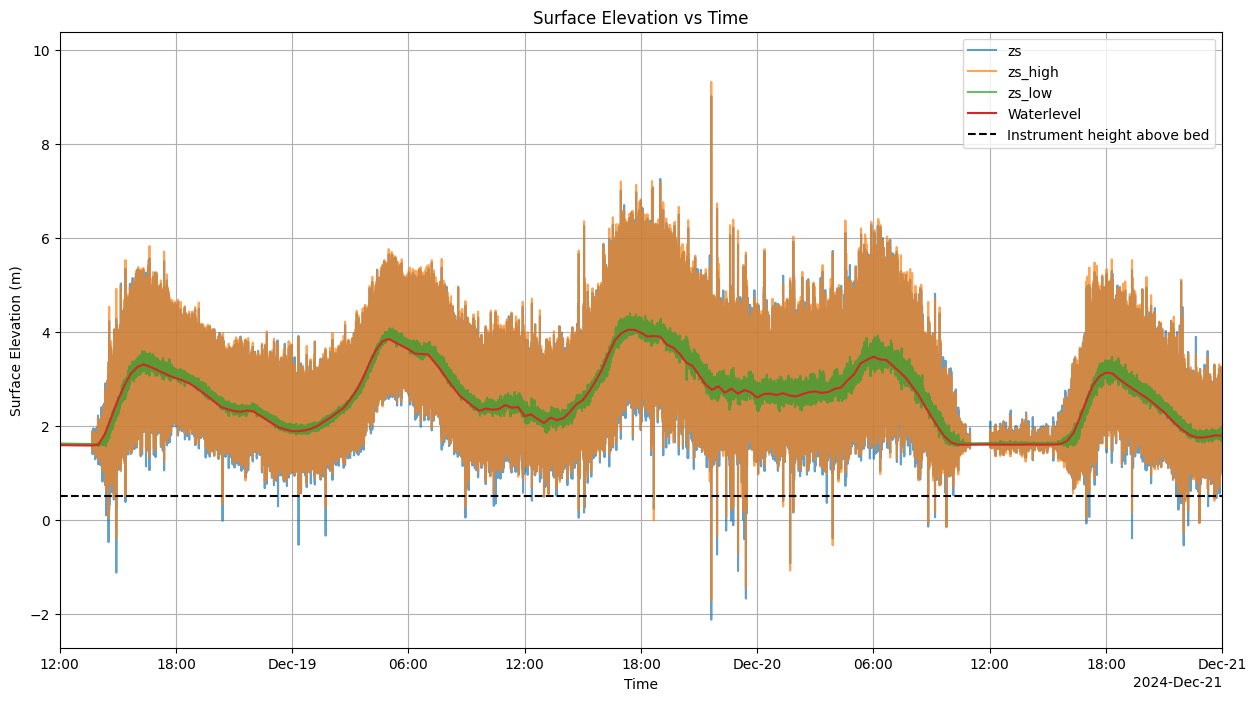

In [33]:
# Plotting
plt.figure(figsize=(15, 8))

plt.plot(t_continuous, zs_flat, label='zs', alpha=0.7)
plt.plot(t_continuous, zs_high_flat, label='zs_high', alpha=0.7)
plt.plot(t_continuous, zs_low_flat, label='zs_low', alpha=0.7)

ds.h.plot(label='Waterlevel')

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-18T12:00:00")
end_time = pd.Timestamp("2024-12-21T00:00:00")
plt.xlim(start_time, end_time)

plt.axhline((ds.zi-ds.zb).values, color='k', linestyle='--', label='Instrument height above bed')

plt.xlabel('Time')
plt.ylabel('Surface Elevation (m)')
plt.title('Surface Elevation vs Time')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

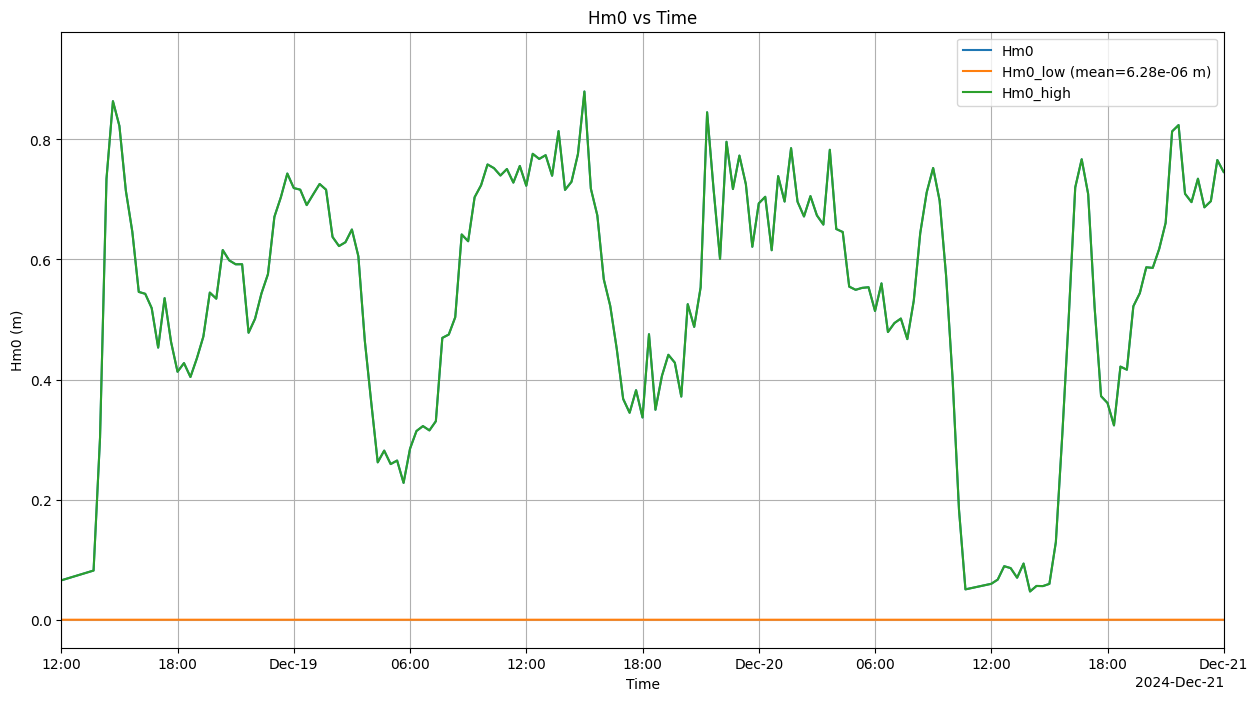

In [34]:
# plot hmo 
plt.figure(figsize=(15, 8))
ds.Hm0.plot(label='Hm0')
ds.Hm0_low.plot(label=f'Hm0_low (mean={ds.Hm0_low.mean().values:.3g} m)')

ds.Hm0_high.plot(label='Hm0_high')
plt.legend()

plt.xlabel('Time')
plt.ylabel('Hm0 (m)')
plt.title('Hm0 vs Time')
plt.grid(True)

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-18T12:00:00")
end_time = pd.Timestamp("2024-12-21T00:00:00")
plt.xlim(start_time, end_time)

plt.show()


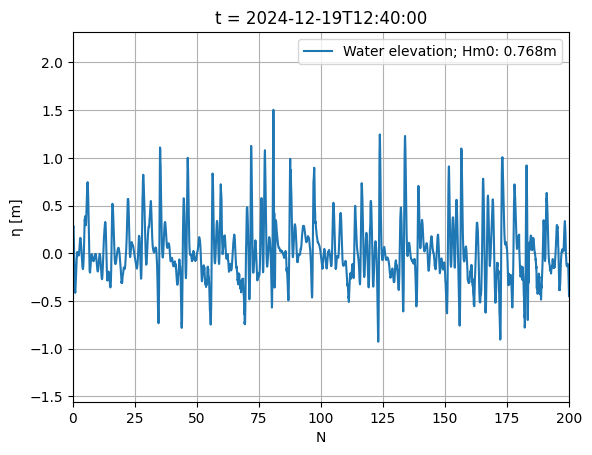

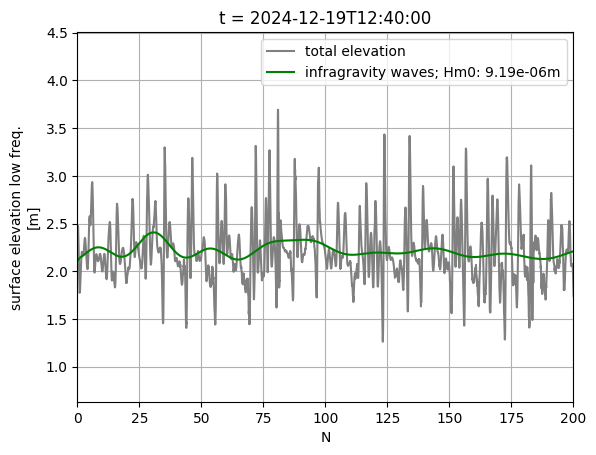

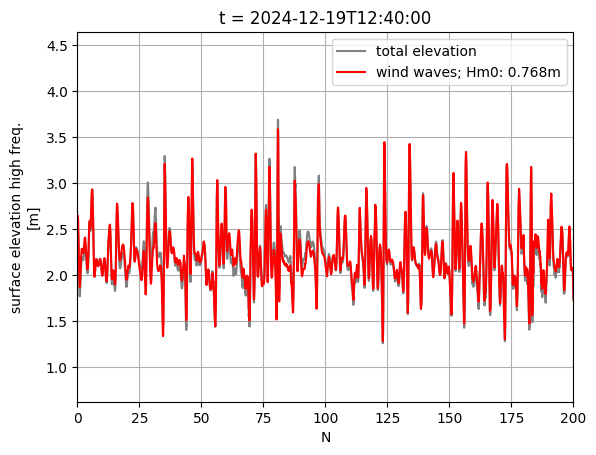

In [35]:
t = 140
end =200

plt.figure()
(ds.zs.isel(t=t)-ds.zs.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
# (ds.zs.isel(t=t)-ds.h.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.ylabel(f'\u03B7 [m]')
plt.legend()

plt.figure()
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_low.isel(t=t).plot(color='green', label = f'infragravity waves; Hm0: {ds.Hm0_low.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.legend()

plt.figure()
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_high.isel(t=t).plot(color='red', label = f'wind waves; Hm0: {ds.Hm0_high.isel(t=t).values:.3g}m')

plt.grid()
plt.xlim(0,end)
plt.legend();

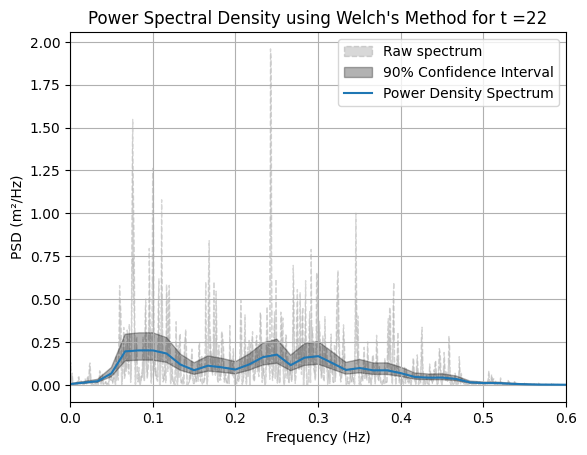

In [36]:
from scipy.stats import chi2
t=22
freq = ds.frequencies.isel(t=t)
psd = ds.psd.isel(t=t)


# Calculate confidence intervals
nBlocks = len(ds.zs.isel(t=t)) // nperseg  # Estimate the number of blocks used by Welch's method
edf = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
alpha = 0.1                  # 90% confidence level

confLow = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit

# Confidence interval bounds for PSD
psd_lower = psd * confLow
psd_upper = psd * confUpper



### background plot 
freq_bg, psd_bg = welch(ds.zs.isel(t=t).values, fs=16, nperseg=19200, detrend='constant', window='hann')
nBlocks_bg = len(ds.zs.isel(t=t).values) // 19200  # Estimate the number of blocks used by Welch's method
edf_bg = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
confLow_bg = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper_bg = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit
psd_lower_bg = psd_bg * confLow_bg
psd_upper_bg = psd_bg * confUpper_bg
# plt.plot(freq_bg, psd_upper_bg, color='gray', linestyle= '--')
plt.fill_between(freq_bg, psd_lower_bg, psd_upper_bg, color='gray', alpha=0.3, label='Raw spectrum', linestyle='--')

### plotting
plt.fill_between(freq, psd_lower, psd_upper, color='black', alpha=0.3, label='90% Confidence Interval')
plt.semilogy(freq, psd, label='Power Density Spectrum')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.title(f'Power Spectral Density using Welch\'s Method for t ={t}')
plt.grid()
plt.yscale('linear')
# plt.xscale('log')
plt.xscale('linear')
plt.xlim(0,0.6)
plt.legend()
plt.show()

In [37]:
def find_time_index(ds, specific_time):
    """
    Function to find the index 't' for a specific time in the dataset.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing the time dimension.
    specific_time (str or datetime): The specific time to find the index for.
    
    Returns:
    int: The index corresponding to the specific time.
    """
    specific_time = np.datetime64(specific_time)
    time_index = np.where(ds.t.values == specific_time)[0]
    
    if len(time_index) == 0:
        raise ValueError(f"Time {specific_time} not found in the dataset.")
    
    return time_index[0]

# Example usage
specific_time = "2024-12-20T12:00:00"
t_index = find_time_index(ds, specific_time)
print(f"The index for the specific time {specific_time} is {t_index}.")

The index for the specific time 2024-12-20T12:00:00 is 207.


In [38]:
print(ds.zi)

<xarray.DataArray 'zi' ()> Size: 8B
array(-0.463)
Attributes:
    units:      m+NAP
    long_name:  z instrument
